In [1]:
import numpy as np
import pandas as pd

In [2]:
from typing import Callable, List, Optional, Tuple
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.max_length
                                                         )["input_ids"]

        attention_mask = [1] * len(tokenized_text)

        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        return self


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoTokenizer, AutoModel

model_names = {
    "herbert-klej-cased-v1": {
        "tokenizer": "allegro/herbert-klej-cased-tokenizer-v1",
        "model": "allegro/herbert-klej-cased-v1",
    },
    "herbert-base-cased": {
        "tokenizer": "allegro/herbert-base-cased",
        "model": "allegro/herbert-base-cased",
    },
    "herbert-large-cased": {
        "tokenizer": "allegro/herbert-large-cased",
        "model": "allegro/herbert-large-cased",
    },
}

tokenizer = AutoTokenizer.from_pretrained(model_names["herbert-base-cased"]["tokenizer"])
bert_model = AutoModel.from_pretrained(model_names["herbert-base-cased"]["model"]) 
bert_transformer = BertTransformer(tokenizer, bert_model)

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [76]:
X = [
    'nlp_5'
    ]

Y = 'GDT_score'

LABELS = [1]

DATASET = 'GDT_NLP_PROCESSING_FULLSTOPS.xlsx'

In [77]:
from sklearn.model_selection import train_test_split
from opening_data import choose_data, get_X_Y

df = choose_data(X, Y, LABELS, DATASET)
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=23)

522
518
518


In [78]:

train_x, train_y = get_X_Y(X, Y, bert_transformer, df_train)

nlp_5


In [79]:

test_x, test_y = get_X_Y(X, Y, bert_transformer, df_test)

nlp_5


In [80]:
from sklearn import svm
vector_regression = svm.SVR(kernel='linear', C=2.2, tol=1e-3)
vector_regression.fit(train_x, train_y)

SVR(C=2.2, kernel='linear')

In [81]:
result = vector_regression.predict(test_x)

In [82]:
from scipy import stats
result = [item if item >= 4 else 4 for item in result]
result = [item if item <= 20 else 20 for item in result]

print(stats.pearsonr(result, test_y))

PearsonRResult(statistic=0.24255426299028318, pvalue=0.013107060860543503)


In [83]:
answers_tuples = [(y, res) for y, res in zip(test_y, result)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(item) for item in result]

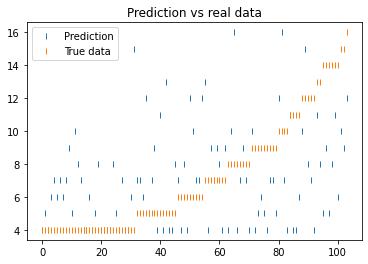

In [84]:
import matplotlib.pyplot as plt



plt.plot(range(len(result)), rounded_result, '|', label="Prediction")
plt.plot(range(len(test_y)), test_y, '|', label='True data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data')
plt.show()